In [3]:
# 训练2天，48小时，画如下几个图：
# 1. loss图2张，每张包含Landlord，LandlordDown，LandlordUP
# 2. ADP和WP图，4张图，每张图是Landlord和Peasants
# 3. WP 对抗SL智能体，ADP对抗SL智能体

In [4]:
# 删掉./log_for_image/下的所有文件
# 删掉./image/下的所有文件

import os
import shutil

# 删除./log_for_image/下的所有文件
log_dir = './log_for_image/'
for filename in os.listdir(log_dir):
    file_path = os.path.join(log_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

# 删除./image/下的所有文件
image_dir = './image/'
for filename in os.listdir(image_dir):
    file_path = os.path.join(image_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [5]:
# 复制数据：
# 将douzero_checkpoints/douzero/logs.csv复制到image/ADP_WP/logs_adp.csv
# 将douzero_checkpoints/douzero/logs.csv复制到image/loss/logs_adp.csv
# 将douzero_checkpoints_wp/douzero/logs.csv复制到image/ADP_WP/logs_adp.csv
# 将douzero_checkpoints_wp/douzero/logs.csv复制到image/loss/logs_wp.csv

import shutil
import os

if not os.path.exists('./log_for_image/ADP_WP/'):
    os.makedirs('./log_for_image/ADP_WP/')
if not os.path.exists('./log_for_image/loss/'):
    os.makedirs('./log_for_image/loss/')

if not os.path.exists('./image/ADP_WP/'):
    os.makedirs('./image/ADP_WP/')
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
# 复制logs.csv到image/ADP_WP/logs_adp.csv
shutil.copy('./douzero_checkpoints/douzero/logs.csv', './log_for_image/ADP_WP/logs_adp.csv')

# 复制logs.csv到image/loss/logs_adp.csv
shutil.copy('./douzero_checkpoints/douzero/logs.csv', './log_for_image/loss/logs_adp.csv')

# 复制logs.csv到image/ADP_WP/logs_wp.csv
shutil.copy('./douzero_checkpoints_wp/douzero/logs.csv', './log_for_image/ADP_WP/logs_wp.csv')

# 复制logs.csv到image/loss/logs_wp.csv
shutil.copy('./douzero_checkpoints_wp/douzero/logs.csv', './log_for_image/loss/logs_wp.csv')

'./log_for_image/loss/logs_wp.csv'

In [6]:
# 函数定义，删除除第一行外的所有header行
def remove_extra_headers(file_path, output_file_path):
    with open(file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
        header_line = next(infile)
        outfile.write(header_line)
        for line in infile:
            if not line.startswith("# _tick"):
                outfile.write(line)

# 处理文件
remove_extra_headers('./log_for_image/ADP_WP/logs_adp.csv', './log_for_image/ADP_WP/logs_adp_processed.csv')
remove_extra_headers('./log_for_image/loss/logs_adp.csv', './log_for_image/loss/logs_adp_processed.csv')
remove_extra_headers('./log_for_image/ADP_WP/logs_wp.csv', './log_for_image/ADP_WP/logs_wp_processed.csv')
remove_extra_headers('./log_for_image/loss/logs_wp.csv', './log_for_image/loss/logs_wp_processed.csv')


In [7]:
import pandas as pd

def shift_time_column(file_path):
    # 读取CSV文件
    df = pd.read_csv(file_path)

    # 将_time列转换为日期时间类型
    df['_time'] = pd.to_datetime(df['_time'], unit='s')

    # 计算时间间隔
    df['time_diff'] = df['_time'].diff()

    # 设置间隔阈值为10分钟
    threshold = pd.Timedelta(minutes=10)

    # 检测大于阈值的时间间隔
    mask = df['time_diff'] > threshold

    # 获取大于阈值的时间间隔的索引
    indices = mask[mask].index

    # 前一大间隔时间的结束
    prev_end_time = df['_time'].iloc[0]

    # 循环处理每个大间隔
    for i in range(len(indices)):
        start_index = indices[i] if i == 0 else indices[i-1] + 1
        end_index = indices[i]

        # 重新设置间隔内的时间
        df.loc[start_index:end_index, '_time'] = prev_end_time + pd.to_timedelta(range(1, end_index-start_index+2), unit='s')

        # 更新前一大间隔时间的结束
        prev_end_time = df['_time'].iloc[end_index]

    # 如果最后一个大间隔后还有数据，还需要处理
    if len(indices) > 0 and indices[-1] < len(df) - 1:
        start_index = indices[-1] + 1
        end_index = len(df) - 1
        df.loc[start_index:end_index+1, '_time'] = prev_end_time + pd.to_timedelta(range(1, end_index-start_index+2), unit='s')

    # 删除中间计算列
    df = df.drop('time_diff', axis=1)

    # 将时间戳转换为整数形式（UNIX时间戳）
    df['_time'] = (df['_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)

    # 保存修改后的数据
    df.to_csv(file_path, index=False)

shift_time_column('./log_for_image/loss/logs_wp_processed.csv')
shift_time_column('./log_for_image/loss/logs_adp_processed.csv')
shift_time_column('./log_for_image/ADP_WP/logs_adp_processed.csv')
shift_time_column('./log_for_image/ADP_WP/logs_wp_processed.csv')


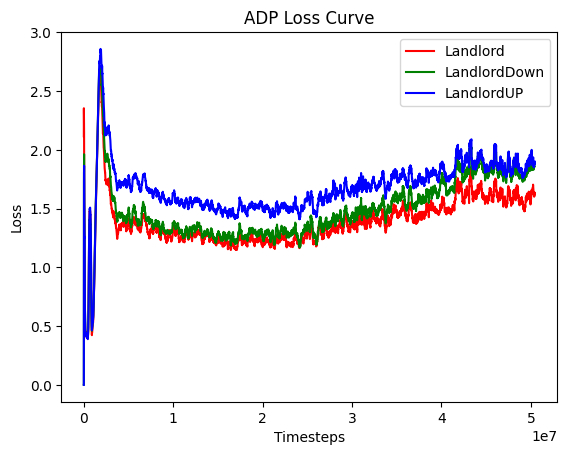

In [8]:
# 绘制的ADP的loss图

# 1. loss图2张，每张包含Landlord，LandlordDown，LandlordUP
# x轴Timesteps, y轴Loss
# Landlord 红色
# LandlordDown 绿色
# LandlordUP 蓝色

# 从./douzero_checkpoints/douzero/logs.csv读取数据
# logs.csv中的数据有多列，其中frames代表timesteps, loss_landlord, loss_landlord_up, loss_landlord_down为对应的损失
# 将图片按照如下格式保存./image/loss/loss_{frames}_landlord_down_up.png
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件中的数据
logs = pd.read_csv(f'./log_for_image/loss/logs_adp_processed.csv')

# 按照timesteps（frames）排序
logs = logs.sort_values(by=['frames'])

# 对每个损失值应用滑动窗口平均函数，使其平滑处理
window_size = 80
logs['smooth_loss_landlord'] = logs['loss_landlord'].rolling(window=window_size, min_periods=1).mean()
logs['smooth_loss_landlord_down'] = logs['loss_landlord_down'].rolling(window=window_size, min_periods=1).mean()
logs['smooth_loss_landlord_up'] = logs['loss_landlord_up'].rolling(window=window_size, min_periods=1).mean()

# 绘制Landlord、LandlordDown和LandlordUP的损失曲线
plt.plot(logs['frames'], logs['smooth_loss_landlord'], color='red', label='Landlord')
plt.plot(logs['frames'], logs['smooth_loss_landlord_down'], color='green', label='LandlordDown')
plt.plot(logs['frames'], logs['smooth_loss_landlord_up'], color='blue', label='LandlordUP')

# 设置标题和轴标签
plt.title('ADP Loss Curve')
plt.xlabel('Timesteps')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 保存图片到本地路径./image/loss/
# 检查文件夹是否存在，不存在则创建
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
filename = './image/loss/adp_loss_{}_landlord_down_up.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

# 显示图表
plt.show()

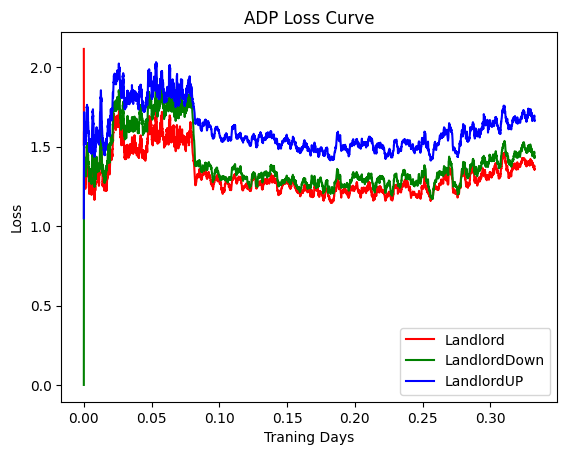

In [9]:
# ADP的loss图
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件中的数据
logs = pd.read_csv(f'./log_for_image/loss/logs_adp_processed.csv')

# 将时间戳转换为datetime格式并按照日期排序
logs['_time'] = pd.to_datetime(logs['_time'], unit='s')

# 计算每个时间点距离最早时间点的天数，并创建一个新列
earliest_time = logs['_time'].min()
logs['days_since_earliest'] = (logs['_time'] - earliest_time).dt.total_seconds() / 86400.

# 按天聚合数据并计算每个组的平均损失值
logs_daily = logs.groupby('days_since_earliest').mean()

# 对每个损失应用滑动窗口平均函数，以平滑处理
window_size = 80
logs_daily['smooth_loss_landlord'] = logs_daily['loss_landlord'].rolling(window=window_size, min_periods=1).mean()
logs_daily['smooth_loss_landlord_down'] = logs_daily['loss_landlord_down'].rolling(window=window_size, min_periods=1).mean()
logs_daily['smooth_loss_landlord_up'] = logs_daily['loss_landlord_up'].rolling(window=window_size, min_periods=1).mean()

# 绘制Landlord、LandlordDown和LandlordUP的损失曲线
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord'], color='red', label='Landlord')
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord_down'], color='green', label='LandlordDown')
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord_up'], color='blue', label='LandlordUP')

# 设置标题和轴标签
plt.title('ADP Loss Curve')
plt.xlabel('Traning Days')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 保存图片到本地路径./image/loss/
# 检查文件夹是否存在，不存在则创建
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
filename = './image/loss/adp_loss_day_{}_landlord_down_up.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

# 显示图表
plt.show()


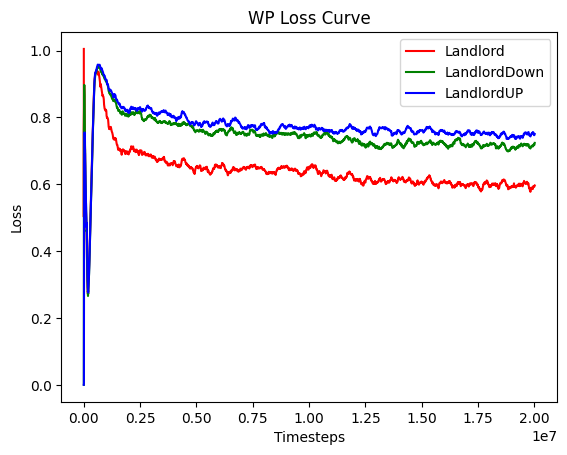

In [10]:
# 绘制的WP的loss图

# 1. loss图2张，每张包含Landlord，LandlordDown，LandlordUP
# x轴Timesteps, y轴Loss
# Landlord 红色
# LandlordDown 绿色
# LandlordUP 蓝色

# 从./douzero_checkpoints/douzero/logs.csv读取数据
# logs.csv中的数据有多列，其中frames代表timesteps, loss_landlord, loss_landlord_up, loss_landlord_down为对应的损失
# 将图片按照如下格式保存./image/loss/loss_{frames}_landlord_down_up.png
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件中的数据
logs = pd.read_csv(f'./log_for_image/loss/logs_wp_processed.csv')

# 按照timesteps（frames）排序
logs = logs.sort_values(by=['frames'])

# 对每个损失值应用滑动窗口平均函数，使其平滑处理
window_size = 80
logs['smooth_loss_landlord'] = logs['loss_landlord'].rolling(window=window_size, min_periods=1).mean()
logs['smooth_loss_landlord_down'] = logs['loss_landlord_down'].rolling(window=window_size, min_periods=1).mean()
logs['smooth_loss_landlord_up'] = logs['loss_landlord_up'].rolling(window=window_size, min_periods=1).mean()

# 绘制Landlord、LandlordDown和LandlordUP的损失曲线
plt.plot(logs['frames'], logs['smooth_loss_landlord'], color='red', label='Landlord')
plt.plot(logs['frames'], logs['smooth_loss_landlord_down'], color='green', label='LandlordDown')
plt.plot(logs['frames'], logs['smooth_loss_landlord_up'], color='blue', label='LandlordUP')

# 设置标题和轴标签
plt.title('WP Loss Curve')
plt.xlabel('Timesteps')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 保存图片到本地路径./image/loss/
# 检查文件夹是否存在，不存在则创建
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
filename = './image/loss/wp_loss_{}_landlord_down_up.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

# 显示图表
plt.show()

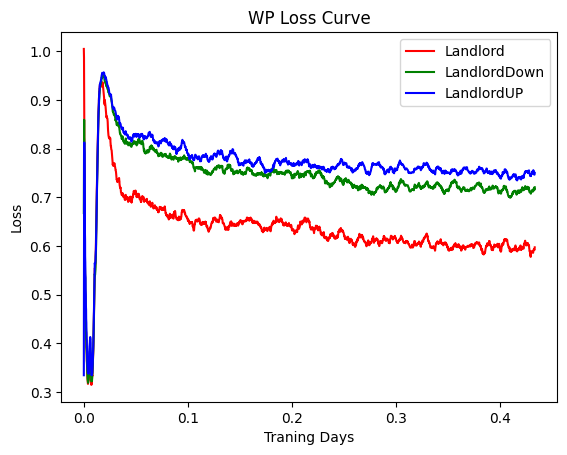

In [11]:
# WP的loss图
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件中的数据
logs = pd.read_csv(f'./log_for_image/loss/logs_wp_processed.csv')

# 将时间戳转换为datetime格式并按照日期排序
logs['_time'] = pd.to_datetime(logs['_time'], unit='s')

# 计算每个时间点距离最早时间点的天数，并创建一个新列
earliest_time = logs['_time'].min()
logs['days_since_earliest'] = (logs['_time'] - earliest_time).dt.total_seconds() / 86400.

# 按天聚合数据并计算每个组的平均损失值
logs_daily = logs.groupby('days_since_earliest').mean()

# 对每个损失应用滑动窗口平均函数，以平滑处理
window_size = 80
logs_daily['smooth_loss_landlord'] = logs_daily['loss_landlord'].rolling(window=window_size, min_periods=1).mean()
logs_daily['smooth_loss_landlord_down'] = logs_daily['loss_landlord_down'].rolling(window=window_size, min_periods=1).mean()
logs_daily['smooth_loss_landlord_up'] = logs_daily['loss_landlord_up'].rolling(window=window_size, min_periods=1).mean()

# 绘制Landlord、LandlordDown和LandlordUP的损失曲线
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord'], color='red', label='Landlord')
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord_down'], color='green', label='LandlordDown')
plt.plot(logs_daily.index, logs_daily['smooth_loss_landlord_up'], color='blue', label='LandlordUP')

# 设置标题和轴标签
plt.title('WP Loss Curve')
plt.xlabel('Traning Days')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 保存图片到本地路径./image/loss/
# 检查文件夹是否存在，不存在则创建
if not os.path.exists('./image/loss/'):
    os.makedirs('./image/loss/')
filename = './image/loss/wp_loss_day_{}_landlord_down_up.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

# 显示图表
plt.show()


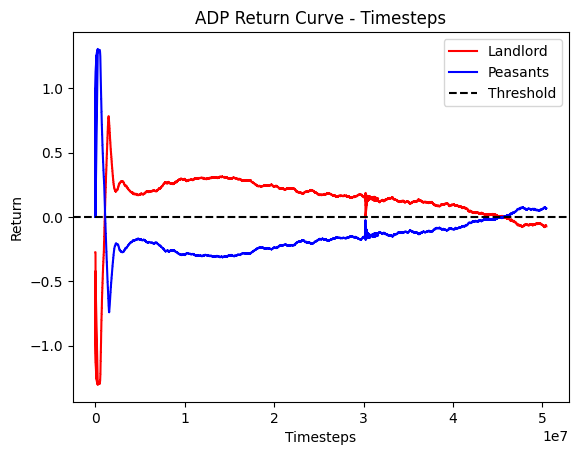

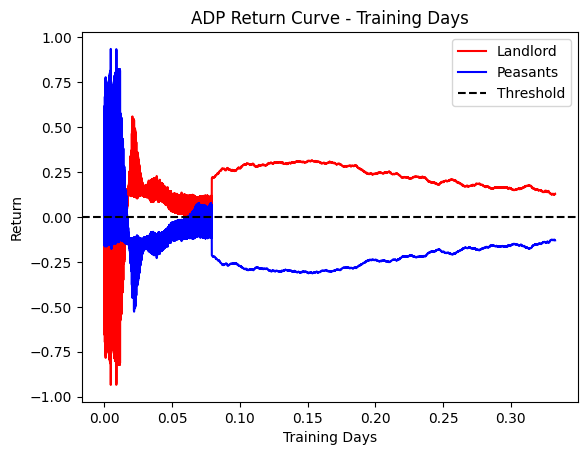

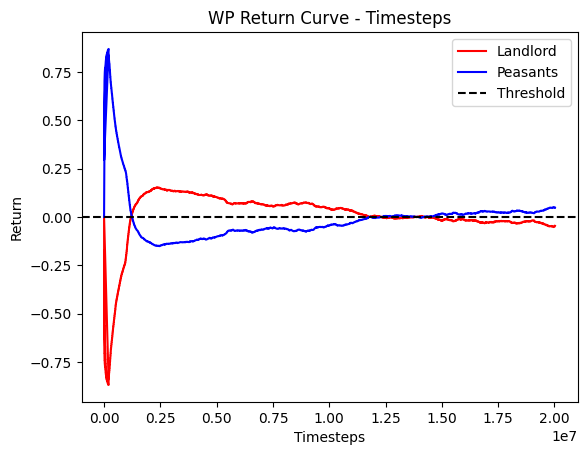

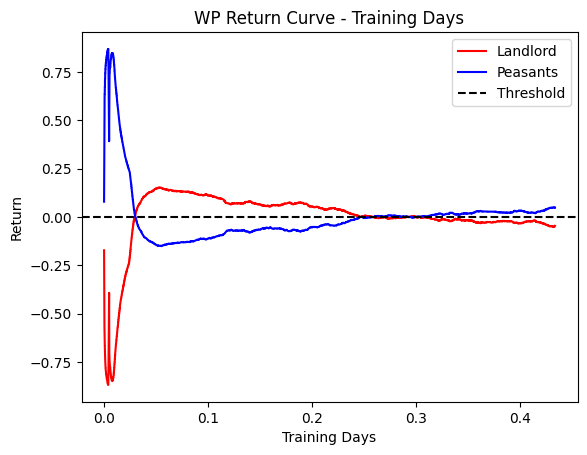

In [12]:
# 2. ADP和WP图，4张图(ADP有2张图，分别是横坐标为Timesteps和Traing Days。WP也有两张图，分别是分别是横坐标为Timesteps和Traing Days)，每张图是Landlord和Peasants
#
# Landlord 红色
# Peasants 蓝色

# ADP图1：横坐标为Timesteps，纵坐标为ADP，Landlord和Peasants
# ADP图2：横坐标为Traing Days，纵坐标为ADP，Landlord和Peasants
# WP图1：横坐标为Timesteps，纵坐标为WP，Landlord和Peasants
# WP图2：横坐标为Traing Days，纵坐标为WP，Landlord和Peasants

# Landlord的数据在csv文件中的mean_episode_return_landlord
# Peasants的数据在csv文件中的mean_episode_return_landlord_up和mean_episode_return_landlord_down，取他们的平均值

# ADP图1：

logs_adp = pd.read_csv(f'./log_for_image/ADP_WP/logs_adp_processed.csv')

logs_adp['mean_episode_return_peasants'] = logs_adp[['mean_episode_return_landlord_up', 'mean_episode_return_landlord_down']].mean(axis=1)

plt.plot(logs_adp['frames'], logs_adp['mean_episode_return_landlord'], color='red', label='Landlord')
plt.plot(logs_adp['frames'], logs_adp['mean_episode_return_peasants'], color='blue', label='Peasants')
plt.axhline(0, color='black', linestyle='--', label='Threshold')

plt.title('ADP Return Curve - Timesteps')
plt.xlabel('Timesteps')
plt.ylabel('Return')

plt.legend()

filename = './image/ADP_WP/adp_return_timesteps_landlord_peasants_{}.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

plt.show()

# ADP图2：

logs_adp['_time'] = pd.to_datetime(logs_adp['_time'], unit='s')
earliest_time = logs_adp['_time'].min()
logs_adp['days_since_earliest'] = (logs_adp['_time'] - earliest_time).dt.total_seconds() / 86400.

logs_daily_adp = logs_adp.groupby('days_since_earliest').mean()

plt.plot(logs_daily_adp.index, logs_daily_adp['mean_episode_return_landlord'], color='red', label='Landlord')
plt.plot(logs_daily_adp.index, logs_daily_adp['mean_episode_return_peasants'], color='blue', label='Peasants')
plt.axhline(0, color='black', linestyle='--', label='Threshold')

plt.title('ADP Return Curve - Training Days')
plt.xlabel('Training Days')
plt.ylabel('Return')

plt.legend()

filename = './image/ADP_WP/adp_return_days_landlord_peasants_{}.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

plt.show()

# WP图1：

logs_wp = pd.read_csv(f'./log_for_image/ADP_WP/logs_wp_processed.csv')

logs_wp['mean_episode_return_peasants'] = logs_wp[['mean_episode_return_landlord_up', 'mean_episode_return_landlord_down']].mean(axis=1)

plt.plot(logs_wp['frames'], logs_wp['mean_episode_return_landlord'], color='red', label='Landlord')
plt.plot(logs_wp['frames'], logs_wp['mean_episode_return_peasants'], color='blue', label='Peasants')
plt.axhline(0, color='black', linestyle='--', label='Threshold')

plt.title('WP Return Curve - Timesteps')
plt.xlabel('Timesteps')
plt.ylabel('Return')

plt.legend()

filename = './image/ADP_WP/wp_return_timesteps_landlord_peasants_{}.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

plt.show()

# WP图2：

logs_wp['_time'] = pd.to_datetime(logs_wp['_time'], unit='s')
earliest_time = logs_wp['_time'].min()
logs_wp['days_since_earliest'] = (logs_wp['_time'] - earliest_time).dt.total_seconds() / 86400.

logs_daily_wp = logs_wp.groupby('days_since_earliest').mean()

plt.plot(logs_daily_wp.index, logs_daily_wp['mean_episode_return_landlord'], color='red', label='Landlord')
plt.plot(logs_daily_wp.index, logs_daily_wp['mean_episode_return_peasants'], color='blue', label='Peasants')
plt.axhline(0, color='black', linestyle='--', label='Threshold')

plt.title('WP Return Curve - Training Days')
plt.xlabel('Training Days')
plt.ylabel('Return')

plt.legend()

filename = './image/ADP_WP/wp_return_days_landlord_peasants_{}.png'.format(int(logs['frames'].max()))
plt.savefig(filename)

plt.show()

In [13]:
# # 执行 nohop python calculate_evaluate_result.py
# nohup python calculate_evaluate_result.py > my_output.txt 2>&1 &


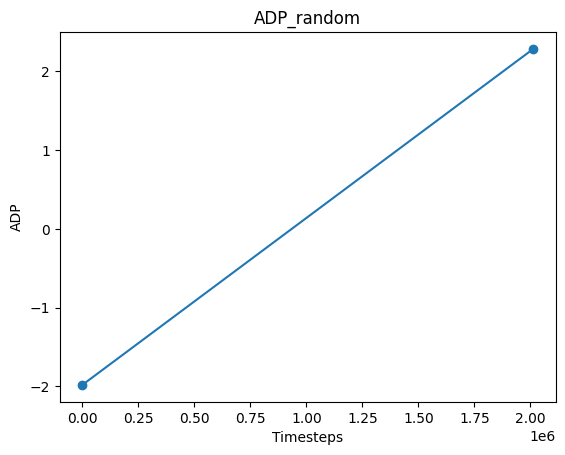

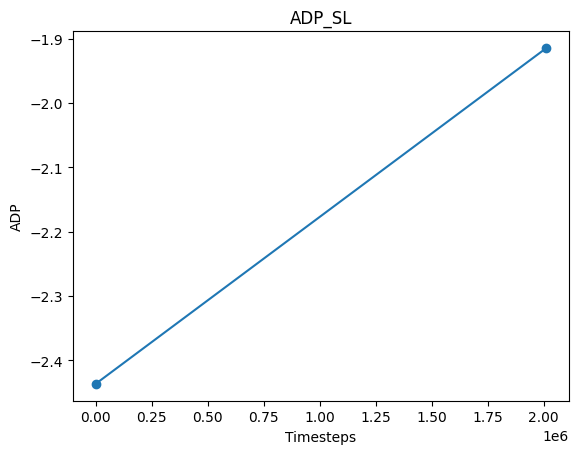

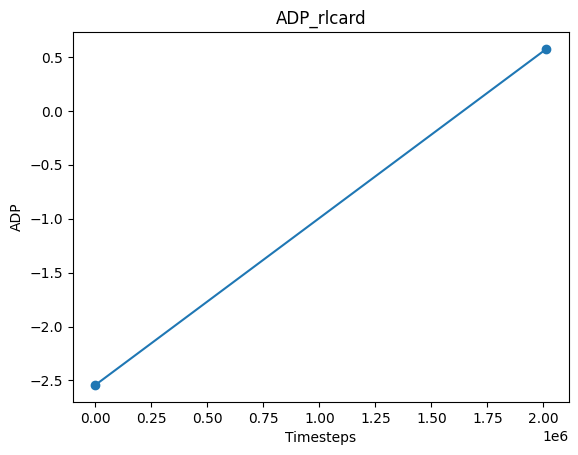

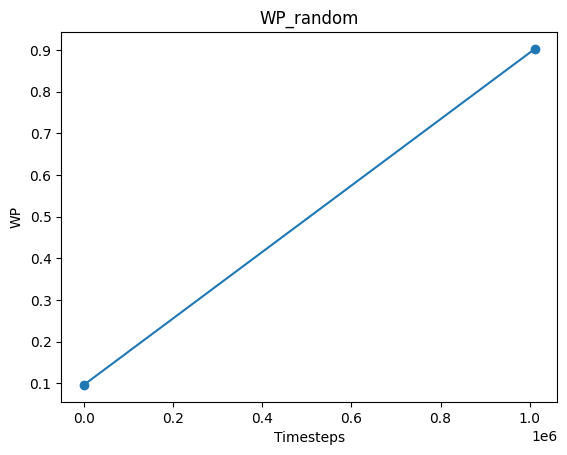

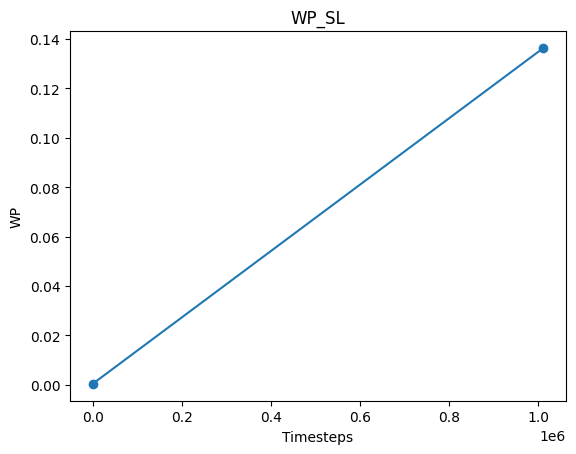

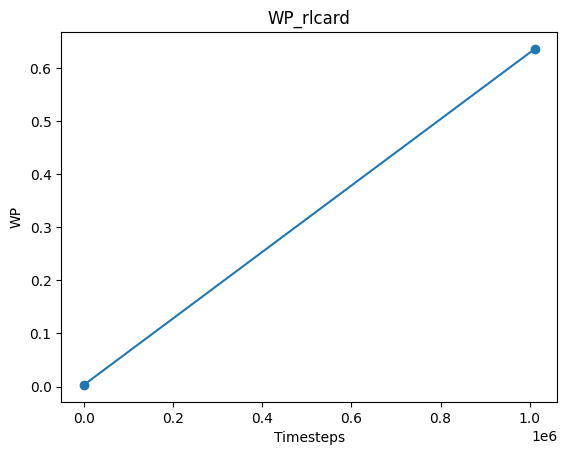

In [14]:
# 3. WP 对抗SL智能体，ADP对抗SL智能体

import matplotlib.pyplot as plt
import os
import re

def extract_data_from_text(text, model_type):
    # Split the text into lines
    lines = text.split('\n')

    # Find the start of the results section for the given model
    start_line = None
    for i, line in enumerate(lines):
        if line.strip() == f"{model_type} results:":
            start_line = i
            break

    if start_line is None:
        return None

    # Find the landlord score line
    for line in lines[start_line:]:
        if line.strip().startswith('landlord'):
            # Extract score
            score_match = re.search(r"landlord\s:\sFarmers\s-\s([-\d\.]+)\s:", line)
            if score_match:
                return float(score_match.group(1))

    return None

def plot_data(data, title, save_dir):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Sort frames in ascending order
    frames = sorted(data.keys())

    # Get corresponding results
    results = [data[frame] for frame in frames]

    # Plot data
    ax.plot(frames, results, marker='o')

    # Set title and labels
    ax.set(xlabel='Timesteps', ylabel='ADP' if 'ADP' in title else 'WP',
           title=title)

    # Save the plot
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{title}.png"))
    # plt.show()

def read_and_plot_files(result_dir, image_dir):
    for subdir, dirs, files in os.walk(result_dir):
        for dir in dirs:
            # Extract model type from the directory name
            model_type = 'ADP' if 'ADP' in dir else 'WP'

            data = {}
            for _, _, files_ in os.walk(os.path.join(result_dir, dir)):
                for file in files_:
                    # Extract frame number from the file name
                    frame = int(re.search(r"_([\d]+)\.ckpt\.txt", file).group(1))
                    
                    with open(os.path.join(subdir, dir, file), 'r') as f:
                        text = f.read()

                    result = extract_data_from_text(text, model_type)

                    if result is not None:
                        data[frame] = result

                if data:
                    # Use the directory name for the plot title and file name
                    plot_data(data, dir, image_dir)

result_dir = "./evaluate_result"
image_dir = "./image/evaluate"
read_and_plot_files(result_dir, image_dir)